# Stochastic NN on full sum

In [1]:
import numpy as np
from matplotlib import pylab as plt

In [2]:
import src.operate_datasets    as operate_datasets
import src.model_visualisation as model_visualisation
import src.model_evaluation    as model_evaluation

Welcome to JupyROOT 6.18/00


## Load data

In [3]:
full_X, full_y = operate_datasets.load_dataset('~/snd_data/new_dataset/', 'sum')

X_train, y_train, _, _ = operate_datasets.split_dataset(full_X, full_y)

In [4]:
X_train.shape

(108000,)

In [5]:
X_train = X_train.reshape(-1, 1)
#y_train = y_train.reshape(-1, 1)

In [6]:
#min_clip = 500
#X_train_clp, y_train_clp = operate_datasets.clip_dataset(X_train, y_train, min_clip)
X_train_clp, y_train_clp = X_train, y_train

## Fit model

In [7]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import constraints
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive

In [8]:
X_tens = torch.tensor(X_train_clp).float()
y_tens = torch.tensor(y_train_clp).float()

In [9]:
X_tens.shape

torch.Size([108000, 1])

In [10]:
class BNN(PyroModule):
    def __init__(self, inp_dim, hid_dim):
        super().__init__()
        
        self.fc1 = PyroModule[nn.Linear](inp_dim, hid_dim)
        self.fc2 = PyroModule[nn.Linear](hid_dim, hid_dim)
        self.fc3 = PyroModule[nn.Linear](hid_dim, 1)

        # register random values that Pyro will work with
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([hid_dim, inp_dim]).to_event(2))
        self.fc1.bias   = PyroSample(dist.Normal(0., 1.).expand([hid_dim]).to_event(1))

        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([hid_dim, hid_dim]).to_event(2))
        self.fc2.bias   = PyroSample(dist.Normal(0., 1.).expand([hid_dim]).to_event(1))

        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([1, hid_dim]).to_event(2))
        self.fc3.bias   = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
        return       


    def forward(self, x, y):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        mu = self.fc3(x).squeeze()

        # Pyro's sampling
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
        
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y.squeeze())
        
        return mu

In [26]:
def run_training(num_iter):
    model = BNN(1, 8)    
    guide = AutoDiagonalNormal(model) 

    predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("obs", "_RETURN"))
    
    adam = pyro.optim.Adam({'lr' : 1e-2})
    #scheduled_adam = pyro.optim.ReduceLROnPlateau({'optimizer': adam, 
    #                                               'optim_args': {'lr' : 1e-3},
    #                                               'patience': 25})
    
    svi = SVI(model, guide, adam, loss=Trace_ELBO())
    
    pyro.clear_param_store()

    loss_arr = []

    for j in range(num_iter):
        running_loss = 0

        loss = svi.step(X_tens, y_tens)
        running_loss += loss

        loss_arr.append(running_loss)
        
        if (j + 1) % 50 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss))

    return model, loss_arr, predictive

In [27]:
# get predictions on the full dataset for analysis

from pyro.infer import Predictive

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std":  torch.std(v, 0),
            "5%":   v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%":  v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

In [41]:
model, loss_arr, predictive = run_training(500)

[iteration 0050] loss: 95622930.2095
[iteration 0100] loss: 10992100.2092
[iteration 0150] loss: 4541314.7100
[iteration 0200] loss: 73414.5093
[iteration 0250] loss: 439383.3310
[iteration 0300] loss: 192423.0370
[iteration 0350] loss: 2480832.5421
[iteration 0400] loss: 183883.8727
[iteration 0450] loss: 150210.5911
[iteration 0500] loss: 68764.6335


In [42]:
samples = predictive(X_tens, y_tens)
pred_summary = summary(samples)

In [43]:
y_pred = pred_summary['_RETURN']['mean'].detach().cpu().numpy()

In [44]:
y_pred

array([0.07290263, 0.15521252, 0.08168616, ..., 0.07137582, 0.05999634,
       0.06522755], dtype=float32)

## Visualise results

In [45]:
X_sum = X_train.sum(axis=1).reshape(-1,1)

In [46]:
y_train = y_train.reshape(-1,1)
y_pred = y_pred.reshape(-1,1)

In [47]:
model_name = 'BNN on full sum'
save_file_prefix = model_name.replace(' ', '-')

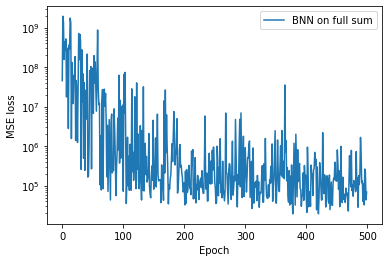

In [48]:
def plot_loss_arrays(loss_dict):
    for key in loss_dict.keys():
        plt.plot(loss_dict[key][0:], label=key)
    
    plt.yscale('log')
    #plt.xscale('log')
    plt.ylabel('MSE loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    return
    
plot_loss_arrays({model_name : loss_arr})

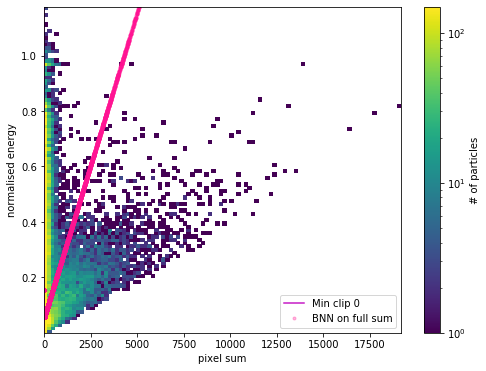

In [49]:
model_visualisation.plot_2d_energy_hist_clip(X_sum, y_train, y_pred, 0, model_name,
                                             save_file_prefix=save_file_prefix) 

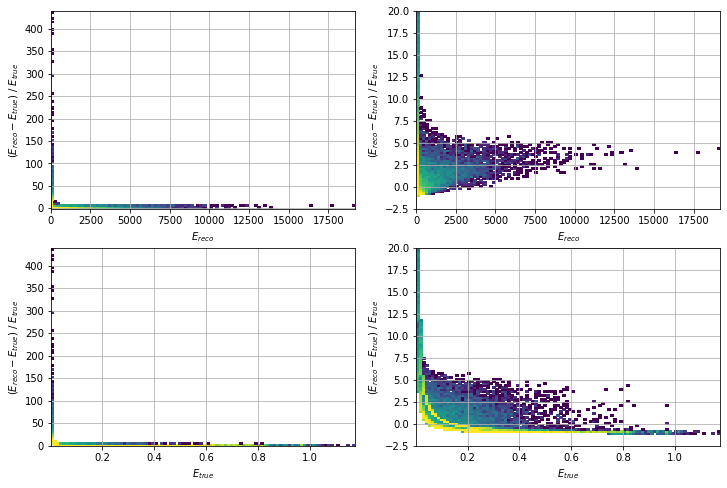

In [50]:
model_visualisation.plot_res_vs_energy(X_sum, y_train, y_pred, vmax=450,
                                       save_file_prefix=save_file_prefix) 

mean   = 6.50775e-01
std    = 5.92244e+00
median = -4.07691e-01


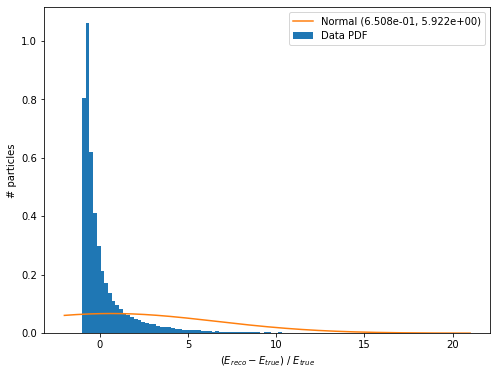

In [51]:
model_visualisation.plot_res_hist_fit(y_train, y_pred, [-1,20],
                                      save_file_prefix=save_file_prefix)

In [52]:
model_evaluation.save_scores(y_train, y_pred, save_file_prefix)

explained_variance_score -0.446316143667181
max_error 3.4659746900958766
mean_absolute_error 0.15628667627278411
mean_squared_error 0.05459065595090636
median_absolute_error 0.09853308992348463
r2_score -0.7063447287640476


,BNN-on-full-sum
explained_variance_score,-0.446316
max_error,3.465975
mean_absolute_error,0.156287
mean_squared_error,0.054591
median_absolute_error,0.098533
r2_score,-0.706345
avg_resolution,0.650775
std_resolution,5.922440


In [53]:
model_evaluation.collect_all_scores()

,Score,L2-on-full-sum-(clipped-data),NN-on-projections,L2-on-projections,NN-on-sum,L2-on-plane-sums,NN-on-plane-sums,NN-on-full-sum,L2-on-true-hits,BNN-on-full-sum
0,explained_variance_score,0.014135,-0.389124,0.050684,0.020719,0.279462,0.141934,0.059597,0.127250,-0.446316
1,max_error,1.003849,1.280791,0.977129,1.044819,1.035705,4.579544,1.036159,0.999070,3.465975
2,mean_absolute_error,0.130024,0.166565,0.129588,0.126946,0.113108,0.117496,0.127036,0.125568,0.156287
3,mean_squared_error,0.032028,0.055521,0.029965,0.033186,0.023052,0.027452,0.030467,0.027922,0.054591
4,median_absolute_error,0.104099,0.115650,0.110256,0.092175,0.092548,0.092858,0.101551,0.107848,0.098533
5,r2_score,-0.001109,-0.735436,0.050683,-0.037294,0.279462,0.141927,0.047684,0.127250,-0.706345
6,avg_resolution,1.729036,0.801541,2.009617,1.320563,1.498581,1.434560,1.623036,1.872374,0.650775
7,std_resolution,7.130151,6.775223,7.685008,5.642022,5.833365,5.486788,6.129634,7.319886,5.922440
